<a href="https://colab.research.google.com/github/JJungEEun/2023_DaconStudy/blob/main/KBO%20%ED%83%80%EC%9E%90%20OPS%20%EC%98%88%EC%B8%A1%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/%EC%A0%95%EC%9D%80/02)preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import pandas as pd
import numpy as np
import os
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
cd /content/drive/MyDrive/2023/데이콘/KBO 타자 OPS 예측 경진대회/data

/content/drive/MyDrive/2023/데이콘/KBO 타자 OPS 예측 경진대회/data


## Data 

In [ ]:
regular = pd.read_csv('Regular_Season_Batter.csv')
pre = pd.read_csv('Pre_Season_Batter.csv')

## 정규시즌 전처리

### 팀

In [ ]:
regular["team"] = regular["team"].apply(team_change)

### 외국인 선수

In [ ]:
foreign = pd.DataFrame({"name":["가르시아", "고메즈", "대니돈", "러프", "로맥", "로메로",
                                "로사리오", "로티노", "로하스", "스나이더", "스크럭스", "알드리지",
                                "초이스", "칸투", "테임즈", "피에", "호잉"]})

In [ ]:
regular.loc[regular["batter_name"].isin(foreign["name"]), "외국인"] = 0
regular.loc[~regular["batter_name"].isin(foreign["name"]), "외국인"] = 1

In [ ]:
regular["외국인"] = regular["외국인"].astype("int")

### 나이

#### 노화곡선

- 연령에 따른 OPS 평균값 확인 > 생존자 편향 문제 발생
  + 19-22살 타자들의 평균 OPS는 프로 입단 초기부터 성적이 좋은 이정후같은 엘리트들이 주로 대상이 됨
  + 반면 39-42살 평균 OPS는 노화가 천천히 진행된 특수한 타자들만 대상이 됨
- 연령별 OPS 평균 X, OPS 평균 변화값 O

```
1) 19살에서 20살로 증가할 때, 해당 선수들의 OPS 평균 변화값

2) 20살에서 21살로 증가할 때, 해당 선수들의 OPS 평균 변화값

3) ...

4) 각 나이별 OPS 평균 변화값 평균
```

In [ ]:
print(regular['batter_id'].value_counts().unique())
print(regular['batter_id'].value_counts().mean())
print(regular['batter_id'].value_counts().median())

[20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1]
7.113043478260869
6.0


In [ ]:
regular2 = regular.groupby(['batter_id']).filter(lambda x: len(x)>=6)
regular2.shape

(1972, 31)

In [ ]:
regular2.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,OBP,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0.000,1,180cm/72kg,1992,0.000,1,72.0,0.0,19,0
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,0.337,6,180cm/72kg,1992,0.686,1,72.0,0.0,22,0
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,0.348,15,180cm/72kg,1992,0.673,1,72.0,0.0,23,1
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,0.232,7,180cm/72kg,1992,0.489,1,72.0,0.0,24,1
5,1,강경학,2017,한화,0.214,59,84,17,18,2,...,0.290,4,180cm/72kg,1992,0.552,1,72.0,0.0,25,1


In [ ]:
regular2['mean_ops'] = regular2.groupby(['batter_id'])['OPS'].transform('mean')

In [ ]:
regular2.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category,mean_ops
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,1,180cm/72kg,1992,0.000,1,72.0,0.0,19,0,0.529
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,6,180cm/72kg,1992,0.686,1,72.0,0.0,22,0,0.529
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,15,180cm/72kg,1992,0.673,1,72.0,0.0,23,1,0.529
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,7,180cm/72kg,1992,0.489,1,72.0,0.0,24,1,0.529
5,1,강경학,2017,한화,0.214,59,84,17,18,2,...,4,180cm/72kg,1992,0.552,1,72.0,0.0,25,1,0.529


In [ ]:
df = regular2.sort_values(['batter_id','age'])
df['ops_diff'] = df['OPS'] - df['mean_ops']

In [ ]:
df['ops_diff'].isna().sum()

17

In [ ]:
df['ops_diff'] = df['ops_diff'].fillna(0)

In [ ]:
sns.set(style='darkgrid')

<AxesSubplot:xlabel='age', ylabel='ops_diff'>

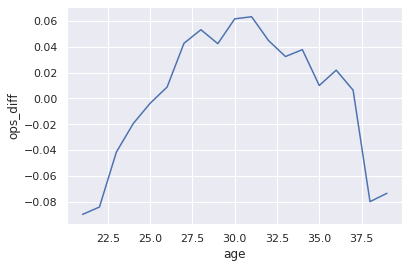

In [ ]:
mean_df = df.groupby(['age'])['ops_diff'].mean().reset_index()
sns.lineplot(x='age',y='ops_diff', data=mean_df[3:-3])

- ..~23세:
- 23~29세: 증가
- 30~..세: 감소

### 나이 범주화
- 위 노화곡선을 바탕으로 나이 범주화

In [ ]:
regular["year_born"] = regular["year_born"].apply(lambda x: int(str(x)[:4]))
regular["age"] = regular["year"] - regular["year_born"]
regular["age_category"] = regular["age"].apply(age_to_category)

### 몸무게 결측치

In [ ]:
regular[regular['height/weight'].isna()==True]['batter_name'].unique()

array(['진갑용', '강병식', '강봉규', '강정호', '고도현', '고동진', '고메즈', '고영민', '이종환',
       '박재홍', '권용관', '김경모', '김경언', '김광연', '박재상', '김대륙', '김동주', '신현철',
       '김연훈', '연경흠', '김원석', '김원섭', '나바로', '김종찬', '김종호', '나성용', '대니돈',
       '로메로', '로사리오', '로티노', '마낙길', '모상기', '문우람', '박계현', '박기남', '박노민',
       '박상규', '박용근', '박준서', '박진만', '박진원', '성의준', '손용석', '송지만', '스나이더',
       '신경현', '신명철', '안치용', '알드리지', '양영동', '오재필', '용덕한', '우동균', '유선정',
       '이종범', '유재혁', '윤완주', '윤요섭', '이명환', '이민재', '이승재', '이양기', '이여상',
       '이우민', '이인구', '이정식', '이태원', '한상훈', '이현곤', '이홍구', '이희근', '임재철',
       '장성호', '전현태', '정보명', '정상교', '정수성', '정현석', '정형식', '조성환', '조영훈',
       '조인성', '조중근', '지재옥', '차일목', '채상병', '최경철', '최동수', '최민구', '최선호',
       '최훈락', '칸투', '테임즈', '피에', '한윤섭', '현재윤', '홍성흔', '황목치승', '황선일',
       '황정립'], dtype=object)

In [ ]:
regular2.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,E,height/weight,year_born,OPS,외국인,weight,weight_category,age,age_category,mean_ops
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,1,180cm/72kg,1992,0.000,1,72.0,0.0,19,0,0.529
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,6,180cm/72kg,1992,0.686,1,72.0,0.0,22,0,0.529
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,15,180cm/72kg,1992,0.673,1,72.0,0.0,23,1,0.529
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,7,180cm/72kg,1992,0.489,1,72.0,0.0,24,1,0.529
5,1,강경학,2017,한화,0.214,59,84,17,18,2,...,4,180cm/72kg,1992,0.552,1,72.0,0.0,25,1,0.529


In [ ]:
import requests
from bs4 import BeautifulSoup
import collections

In [ ]:
noHW_batter = regular[regular['height/weight'].isna()==True]['batter_name'].unique()

In [ ]:
for batter in noHW_batter:
  response = requests.get('https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query='+batter+'야구')
  soup = BeautifulSoup(response.content, 'html.parser')
  table = soup.select(".detail_info > .txt_3 > .info_group > dd")
  
  for a in table:
    if a.string:
      if a.string.endswith('kg'):
        print(batter,a.string[1:])
        regular.loc[regular['batter_name']==batter, 'height/weight']=a.string[1:]

백승룡 180cm, 80kg
진갑용 182cm, 90kg
강병식 182cm, 85kg
강봉규 183cm, 88kg
강정호 183cm, 99.8kg
고도현 182cm, 97kg
고동진 183cm, 85kg
고영민 182cm, 72kg
이종환 175cm, 90kg
권용관 180cm, 80kg
김경모 177cm, 72kg
김경언 188cm, 84kg
김광연 181cm, 76kg
박재상 178cm, 83kg
김대륙 185cm, 82kg
김동주 190cm, 90kg
신현철 179cm, 73kg
김연훈 180cm, 80kg
연경흠 176cm, 78kg
김원석 182cm, 83kg
김원섭 180cm, 75kg
김종호 183cm, 82kg
나성용 183cm, 94kg
대니돈 186cm, 92kg
마낙길 178cm, 75kg
모상기 193cm, 100kg
문우람 177cm, 80kg
박계현 181cm, 82kg
박기남 175cm, 80kg
박상규 185cm, 88kg
박용근 172cm, 76kg
박준서 180cm, 80kg
박진만 178cm, 82kg
성의준 178cm, 76kg
손용석 176cm, 88kg
송지만 178cm, 85kg
신경현 186cm, 95kg
신명철 181cm, 77kg
안치용 183cm, 90kg
양영동 173cm, 70kg
용덕한 176cm, 82kg
우동균 175cm, 68kg
유선정 180cm, 82kg
이종범 178cm, 73kg
유재혁 182cm, 70kg
윤요섭 180cm, 96kg
이명환 188cm, 94kg
이민재 177cm, 77kg
이승재 182cm, 82kg
이양기 185cm, 88kg
이정식 183cm, 90kg
이태원 177cm, 78kg
한상훈 178cm, 78kg
이현곤 183cm, 83kg
이홍구 180cm, 95kg
이희근 178cm, 84kg
임재철 182cm, 89kg
정보명 177cm, 80kg
정상교 177cm, 73kg
정수성 173cm, 72kg
정현석 182cm, 93kg
정형식 178cm, 74kg
조성환 1

In [ ]:
regular[regular['height/weight'].isna()==True]['batter_name'].unique()
# 네이버 인물검색에 안뜸 !

array(['고메즈', '박재홍', '나바로', '김종찬', '로메로', '로사리오', '로티노', '박노민', '박진원',
       '스나이더', '알드리지', '오재필', '윤완주', '이여상', '이우민', '이인구', '장성호', '전현태',
       '최동수', '칸투', '테임즈', '피에'], dtype=object)

In [ ]:
regular.loc[regular['batter_name']=='고메즈', 'height/weight'] = '188cm/88kg'
regular.loc[regular['batter_name']=='박재홍', 'height/weight'] = '176cm/85kg'
regular.loc[regular['batter_name']=='나바로', 'height/weight'] = '183cm/93kg'
regular.loc[regular['batter_name']=='김종찬', 'height/weight'] = '188cm/102kg'
regular.loc[regular['batter_name']=='로메로', 'height/weight'] = '188cm/102kg'
regular.loc[regular['batter_name']=='로사리오', 'height/weight'] = '180cm/100kg'
regular.loc[regular['batter_name']=='로티노', 'height/weight'] = '183cm/86kg'
regular.loc[regular['batter_name']=='박노민', 'height/weight'] = '182cm/93kg'
regular.loc[regular['batter_name']=='박지원', 'height/weight'] = '186cm, 85kg'
regular.loc[regular['batter_name']=='스나이더', 'height/weight'] = '192cm/96kg'
regular.loc[regular['batter_name']=='알드리지', 'height/weight'] = '185cm/102kg'
regular.loc[regular['batter_name']=='오재필', 'height/weight'] = '181cm/83kg'
regular.loc[regular['batter_name']=='윤완주', 'height/weight'] = '178cm, 84kg'
regular.loc[regular['batter_name']=='이여상', 'height/weight'] = '183cm/84kg'
regular.loc[regular['batter_name']=='이우민', 'height/weight'] = '182cm/85kg'
regular.loc[regular['batter_name']=='이인구', 'height/weight'] = '186cm/94kg'
regular.loc[regular['batter_name']=='장성호', 'height/weight'] = '183cm/93kg'
regular.loc[regular['batter_name']=='전현태', 'height/weight'] = '184cm/87kg'
regular.loc[regular['batter_name']=='최동수', 'height/weight'] = '186cm/98kg'
regular.loc[regular['batter_name']=='칸투', 'height/weight'] = '192cm/92kg'
regular.loc[regular['batter_name']=='테임즈', 'height/weight'] = '180cm/106kg'
regular.loc[regular['batter_name']=='피에', 'height/weight'] = '188cm/86kg'
regular.loc[regular['batter_name']=='박진원', 'height/weight'] = '179cm, 75kg'

# http://www.kbreport.com/main 바탕으로 수기로 넣어줌

In [ ]:
regular['height/weight'].isna().sum()

0

In [ ]:
regular['weight'] = regular['height/weight'].apply(weigth)
regular["weight_category"] = regular["weight"].apply(weight_to_category)

In [ ]:
regular.head(3)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,year_born,position,career,starting_salary,OPS,외국인,age,age_category,weight,weight_category
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,1985,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,0,33,2,93,2
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,1992,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,1,19,0,72,0
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,1992,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,1,22,0,72,0


In [ ]:
regular.drop(["career", "starting_salary", "position"], axis=1, inplace=True)

In [ ]:
regular.to_csv("Regular_Season_Batter_pre(2).csv", index=None)

## 프리시즌 전처리

In [ ]:
pre["team"] = pre["team"].apply(team_change)

In [ ]:
pre.loc[regular["batter_name"].isin(foreign["name"]), "외국인"] = 0
pre.loc[~regular["batter_name"].isin(foreign["name"]), "외국인"] = 1

In [ ]:
pre['height/weight'].isna().sum()

0

In [ ]:
pre["weight"] = pre['height/weight'].apply(weigth)
pre["weight_category"] = pre["weight"].apply(weight_to_category)

In [ ]:
pre["year_born"] = pre["year_born"].apply(lambda x: int(str(x)[:4]))
pre["age"] = pre["year"] - pre["year_born"]
pre["age_category"] = pre["age"].apply(age_to_category)

In [ ]:
pre.drop(["career", "starting_salary", "position"], axis=1, inplace=True)

In [ ]:
pre.to_csv("Pre_Season_Batter_pre(2).csv", index=None)

## library

In [ ]:
# 팀 통합
def team_change(team):

    if team == "쌍방울":
        team = "SK"

    elif team == "OB":
        team = "두산"
    
    elif team == "해태":
        team = "KIA"

    elif team == "우리":
        team = "넥센"
    
    elif team == "히어로즈":
        team = "넥센"

    else:
        team

    return team

In [ ]:
# 몸무게로 변환
def weigth(kg):

    # 몸무게가 3자리인 선수 고려
    if len(kg) == 11:

        kg = str(kg)[6:9]

    else:
        kg = str(kg)[6:8]

    return int(kg)

In [ ]:
# 몸무게 범주화
def weight_to_category(kg):

    if kg >= 94:
        
        x = int(3)

    elif kg >= 85:

        x = int(2)

    elif kg >= 78:

        x = int(1)

    elif kg >= 0 and kg < 78:

        x = int(0)

    else:

        x = np.NaN

    return x

In [ ]:
# 나이 범주화
def age_to_category(age):
    if age >= 38:

        age = 3

    elif age >= 29:
        
        age = 2

    elif age >= 23:

        age = 1

    else:

        age = 0

    return age